In [26]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import qiskit.circuit.library as qlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm
%matplotlib inline

In [27]:
#parameters

M = 16 # lattices

dim = 2
dirs = 5
nlat = int(np.ceil(np.log2(M)))
nlinks = int(np.ceil(np.log2(dirs)))
#center, right, left, up, down
wts = (2/6,1/6,1/6,1/6,1/6)
e = (0,-1,1,-1,1) 
cs = np.sqrt(3) 
U = 1 #velocity of moving wall for cavity flow    

In [28]:
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

In [29]:
def uv(streamfunc):
    #u = streamfunction_y, v = -streamfunction_x
    streamfunc = np.reshape(streamfunc,(M,M))
    v = (streamfunc[:,1:]-streamfunc[:,:-1])
    u = streamfunc[1:,:]-streamfunc[:-1,:]
    
    v = np.append(v,np.reshape(v[:,-1],(M,1)),axis=1)
    u = np.append(u,u[-1:],axis=0)
    
    v*=-1
    streamfunc = np.reshape(streamfunc,(M*M))
    return u,v

def collision_f(u_vels, v_vels):
    # for f, weights have to be calculated by advection diffusion eq, but u and v must be calculated
    def coef(link,vel):
        return wts[link]*(1+e[link]*vel/cs**2)
    func = np.vectorize(coef)
    
    ret = np.zeros((5,M,M))
    ret[0] = func(0,np.zeros((M,M)))
    ret[1] = func(1,u_vels)
    ret[2] = func(2,u_vels)
    ret[3] = func(3,v_vels)
    ret[4] = func(4,v_vels)
    return ret.flatten()

def collision_g():
    return np.concatenate(([wts[0]]*M*M,[wts[1]]*M*M,[wts[2]]*M*M,[wts[3]]*M*M,[wts[4]]*M*M))

def source_coeffs():
    return collision_g()

def boundary_coeffs():
    return 1/np.sqrt(2)*np.ones(M*M)

In [30]:
def top_half(A):
    def convert(val):
        return val+1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)
def bottom_half(A):
    def convert(val):
        return val-1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)

In [31]:
def calcBounds(streamfunction):
    sf = np.reshape(streamfunction,(M,M))
    arr = np.zeros((M,M))
    arr[-1] = -2*sf[-2]
    arr[:,0] = -2*sf[:,1]
    arr[:,-1] = -2*sf[:,-2]
    arr[0] = -2*sf[1]-2*U
    return arr

In [32]:
def createAdiag(streamfunction):
    uvels, vvels = uv(streamfunction[:M*M])
    tmp = collision_f(uvels,vvels)
    A_diag = np.concatenate((tmp,collision_g(),source_coeffs(),boundary_coeffs()))
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    return B1_diag, B2_diag

In [33]:
def createBDiag():
    A_diag = np.ones((M,M))
    A_diag[0] = 0
    A_diag[-1] = 0
    A_diag[:,0] = 0
    A_diag[:,-1] = 0
    A_diag = A_diag.flatten()
    
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    return B1_diag, B2_diag

In [34]:
def createCirc(streamfunction):
    q = QuantumRegister(nlat+nlat+nlinks+1+1,'q')
    a = AncillaRegister(2,'a')

    setup = QuantumCircuit(q)
    setup.add_register(a)

    #collisions
    B1_diag, B2_diag = createAdiag(streamfunction)
    B = QuantumCircuit(QuantumRegister(nlat+nlat+nlinks+1+1))
    B.diagonal(list(np.concatenate((B1_diag,B2_diag))),qubit = [0,1,2,3,4,5,6,7,8,9,10,11,12])
    B = B.to_gate(label='B')

    setup.append(B,q)
    setup.h(a[0])
    setup.swap(a[0],q[-1])
    # setup.swap(a[1],q[-1])#test
    setup.h(a[0])
    #     #adding source term
    S0s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001010')
    S0e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100101')
    S1s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001011')
    S1e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100110')
    S2s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001100')
    S2e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100111')
    S3s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001101')
    S3e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='101000')
    S4s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001110')
    S4e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='101001')

    ht1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00101') # test
    ht2 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00110') # test
    ht3 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00111') # test
    ht4 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='01000') # test
    ht5 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='01001') # test

    setup.append(S0s,[8,9,10,11,12,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1],11)
    setup.cx(a[1],10)
    setup.cx(a[1],9)
    setup.cx(a[1],8)
    setup.append(S0e,[8,9,10,11,12,a[0],a[1]])
    # setup.append(ht1,[8,9,10,11,12,a[0]])

    setup.append(S1s,[8,9,10,11,12,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1],11)
    setup.cx(a[1],10)
    setup.cx(a[1],8)
    setup.append(S1e,[8,9,10,11,12,a[0],a[1]])
    # setup.append(ht2,[8,9,10,11,12,a[0]])

    setup.append(S2s,[8,9,10,11,12,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1],11)
    setup.cx(a[1],9)
    setup.cx(a[1],8)
    setup.append(S2e,[8,9,10,11,12,a[0],a[1]])
    # setup.append(ht3,[8,9,10,11,12,a[0]])

    setup.append(S3s,[8,9,10,11,12,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1],10)
    setup.cx(a[1],8)
    setup.append(S3e,[8,9,10,11,12,a[0],a[1]])
    # setup.append(ht4,[8,9,10,11,12,a[0]])

    setup.append(S4s,[8,9,10,11,12,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1],10)
    setup.cx(a[1],9)
    setup.cx(a[1],8)
    setup.append(S4e,[8,9,10,11,12,a[0],a[1]])
    # setup.append(ht5,[8,9,10,11,12,a[0]])

    setup.h(a[0])


    # #propagation
    setup.barrier()
        #vorticity
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0000001') # right 1
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0000010') # left 2
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0000011') # up 3
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0000100') # down 4
        #streamfunction
    R3 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0000110') # right 6
    L3 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0000111') # left 7
    L4 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0001000') # up 8
    R4 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0001001') # down 9

    setup.append(R1,[8,9,10,11,12,a[0],a[1],3,2,1,0])
    setup.append(L1,[8,9,10,11,12,a[0],a[1],3,2,1,0])
    setup.append(L2,[8,9,10,11,12,a[0],a[1],7,6,5,4])
    setup.append(R2,[8,9,10,11,12,a[0],a[1],7,6,5,4])

    setup.append(R3,[8,9,10,11,12,a[0],a[1],3,2,1,0])
    setup.append(L3,[8,9,10,11,12,a[0],a[1],3,2,1,0])
    setup.append(L4,[8,9,10,11,12,a[0],a[1],7,6,5,4])
    setup.append(R4,[8,9,10,11,12,a[0],a[1],7,6,5,4])


    setup.barrier()

    # #macros
    #     #vorticity
    Hv1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00000')
    Hv2 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='10000')
    Hv3 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='10000')
    Hv4 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00000')
    Hv5 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='10000')
    Hv6 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00000')
    Sv1 = qlib.SwapGate().control(num_ctrl_qubits = 4, label = None, ctrl_state = '0000')
    Xv1 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='110000')
    Xv2 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100001')
    Xv3 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='110000')

    setup.append(Hv1,[a[0],12,11,10,9,8])
    setup.append(Hv2,[a[0],12,11,10,9,8])
    setup.append(Sv1,[a[0],12,11,9,10,8])
    setup.append(Xv1,[a[0],12,11,10,9,8,a[1]])
    setup.append(Hv3,[a[0],12,11,10,8,9])
    setup.append(Hv4,[a[0],12,11,10,9,8])
    setup.append(Xv2,[a[1],a[0],12,11,10,9,8])
    setup.append(Xv3,[a[0],12,11,10,9,8,a[1]])
    setup.append(Hv5,[a[0],12,11,10,9,8])
    setup.append(Hv6,[a[0],12,11,10,8,9])

    #     #streamfunction
    Hs1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Hs2 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00100')
    Hs3 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Hs4 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Hs5 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00100')
    Hs6 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')

    Xs1 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='111000')
    Xs2 = qlib.XGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Xs3 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100100')
    Xs4 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='000100')
    Xs5 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='111000')

    setup.barrier()
    setup.append(Hs1,[a[0],12,11,10,8,9])
    setup.append(Hs2,[a[0],12,11,10,9,8])
    setup.append(Xs1,[a[0],12,11,10,9,8,a[1]])
    setup.append(Hs3,[a[0],12,11,10,9,8])
    setup.append(Xs2,[a[0],12,11,10,9,8])
    setup.append(Hs4,[a[0],12,11,10,8,9])
    setup.append(Xs3,[a[0],12,11,10,9,8,a[1]])
    setup.append(Hs5,[a[0],12,11,10,9,8])
    setup.append(Xs4,[a[0],12,11,10,9,8,a[1]])
    setup.cx(a[1],11)
    setup.cx(a[1],10)
    setup.cx(a[1],9)
    setup.cx(a[1],8)
    setup.append(Xs5,[a[0],12,11,10,9,8,a[1]])
    setup.append(Hs6,[a[0],12,11,10,8,9])

        ##boundaries

    q2 = QuantumRegister(nlat+nlat+nlinks+1+1,'q')
    a2 = AncillaRegister(2,'a')

    setup2 = QuantumCircuit(q2)
    setup2.add_register(a2)


    setup2.barrier()
    Hb1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11100')
    Hb2 = qlib.HGate().control(num_ctrl_qubits=4,label = None, ctrl_state='1100')
    Hb3 = qlib.HGate().control(num_ctrl_qubits=4,label = None, ctrl_state='0000')
    Hb4 = qlib.HGate().control(num_ctrl_qubits=4,label = None, ctrl_state='0000')

    Sb1 = qlib.SwapGate().control(num_ctrl_qubits = 3, label = None, ctrl_state = '100')

    Xb1 = qlib.XGate().control(num_ctrl_qubits=4,label = None, ctrl_state='0001')
    Xb2 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100000')
    Xb3 = qlib.XGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00001')
    Xb4 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='000001')

    setup2.append(Hb1,[a2[0],12,11,10,9,8])
    setup2.append(Hb2,[a2[0],12,11,10,9])
    setup2.append(Xb1,[a2[1],a2[0],11,10,12])
    setup2.append(Xb2,[a2[1],a2[0],12,11,9,8,10])
    setup2.append(Hb3,[a2[0],12,11,10,a2[1]])

    ####CB gate
    CB1_diag, CB2_diag = createBDiag()
    CB = QuantumCircuit(QuantumRegister(9))
    CB.diagonal(list(np.concatenate((CB1_diag, CB2_diag))),qubit = [0,1,2,3,4,5,6,7,8])
    CB = CB.to_gate(label='CB')

    setup2.barrier()
    setup2.append(CB.control(ctrl_state = 0),[10,0,1,2,3,4,5,6,7,8])
    setup2.barrier()

    setup2.append(Hb4,[a2[0],12,11,10,a2[1]])
    setup2.append(Xb3,[a2[1],a2[0],12,11,10,9])
    setup2.append(Sb1,[a2[0],12,11,a2[1],10])
    setup2.append(Xb4,[a2[1],a2[0],12,10,9,8,11])
    setup2.h(a2[1])
    return setup, setup2

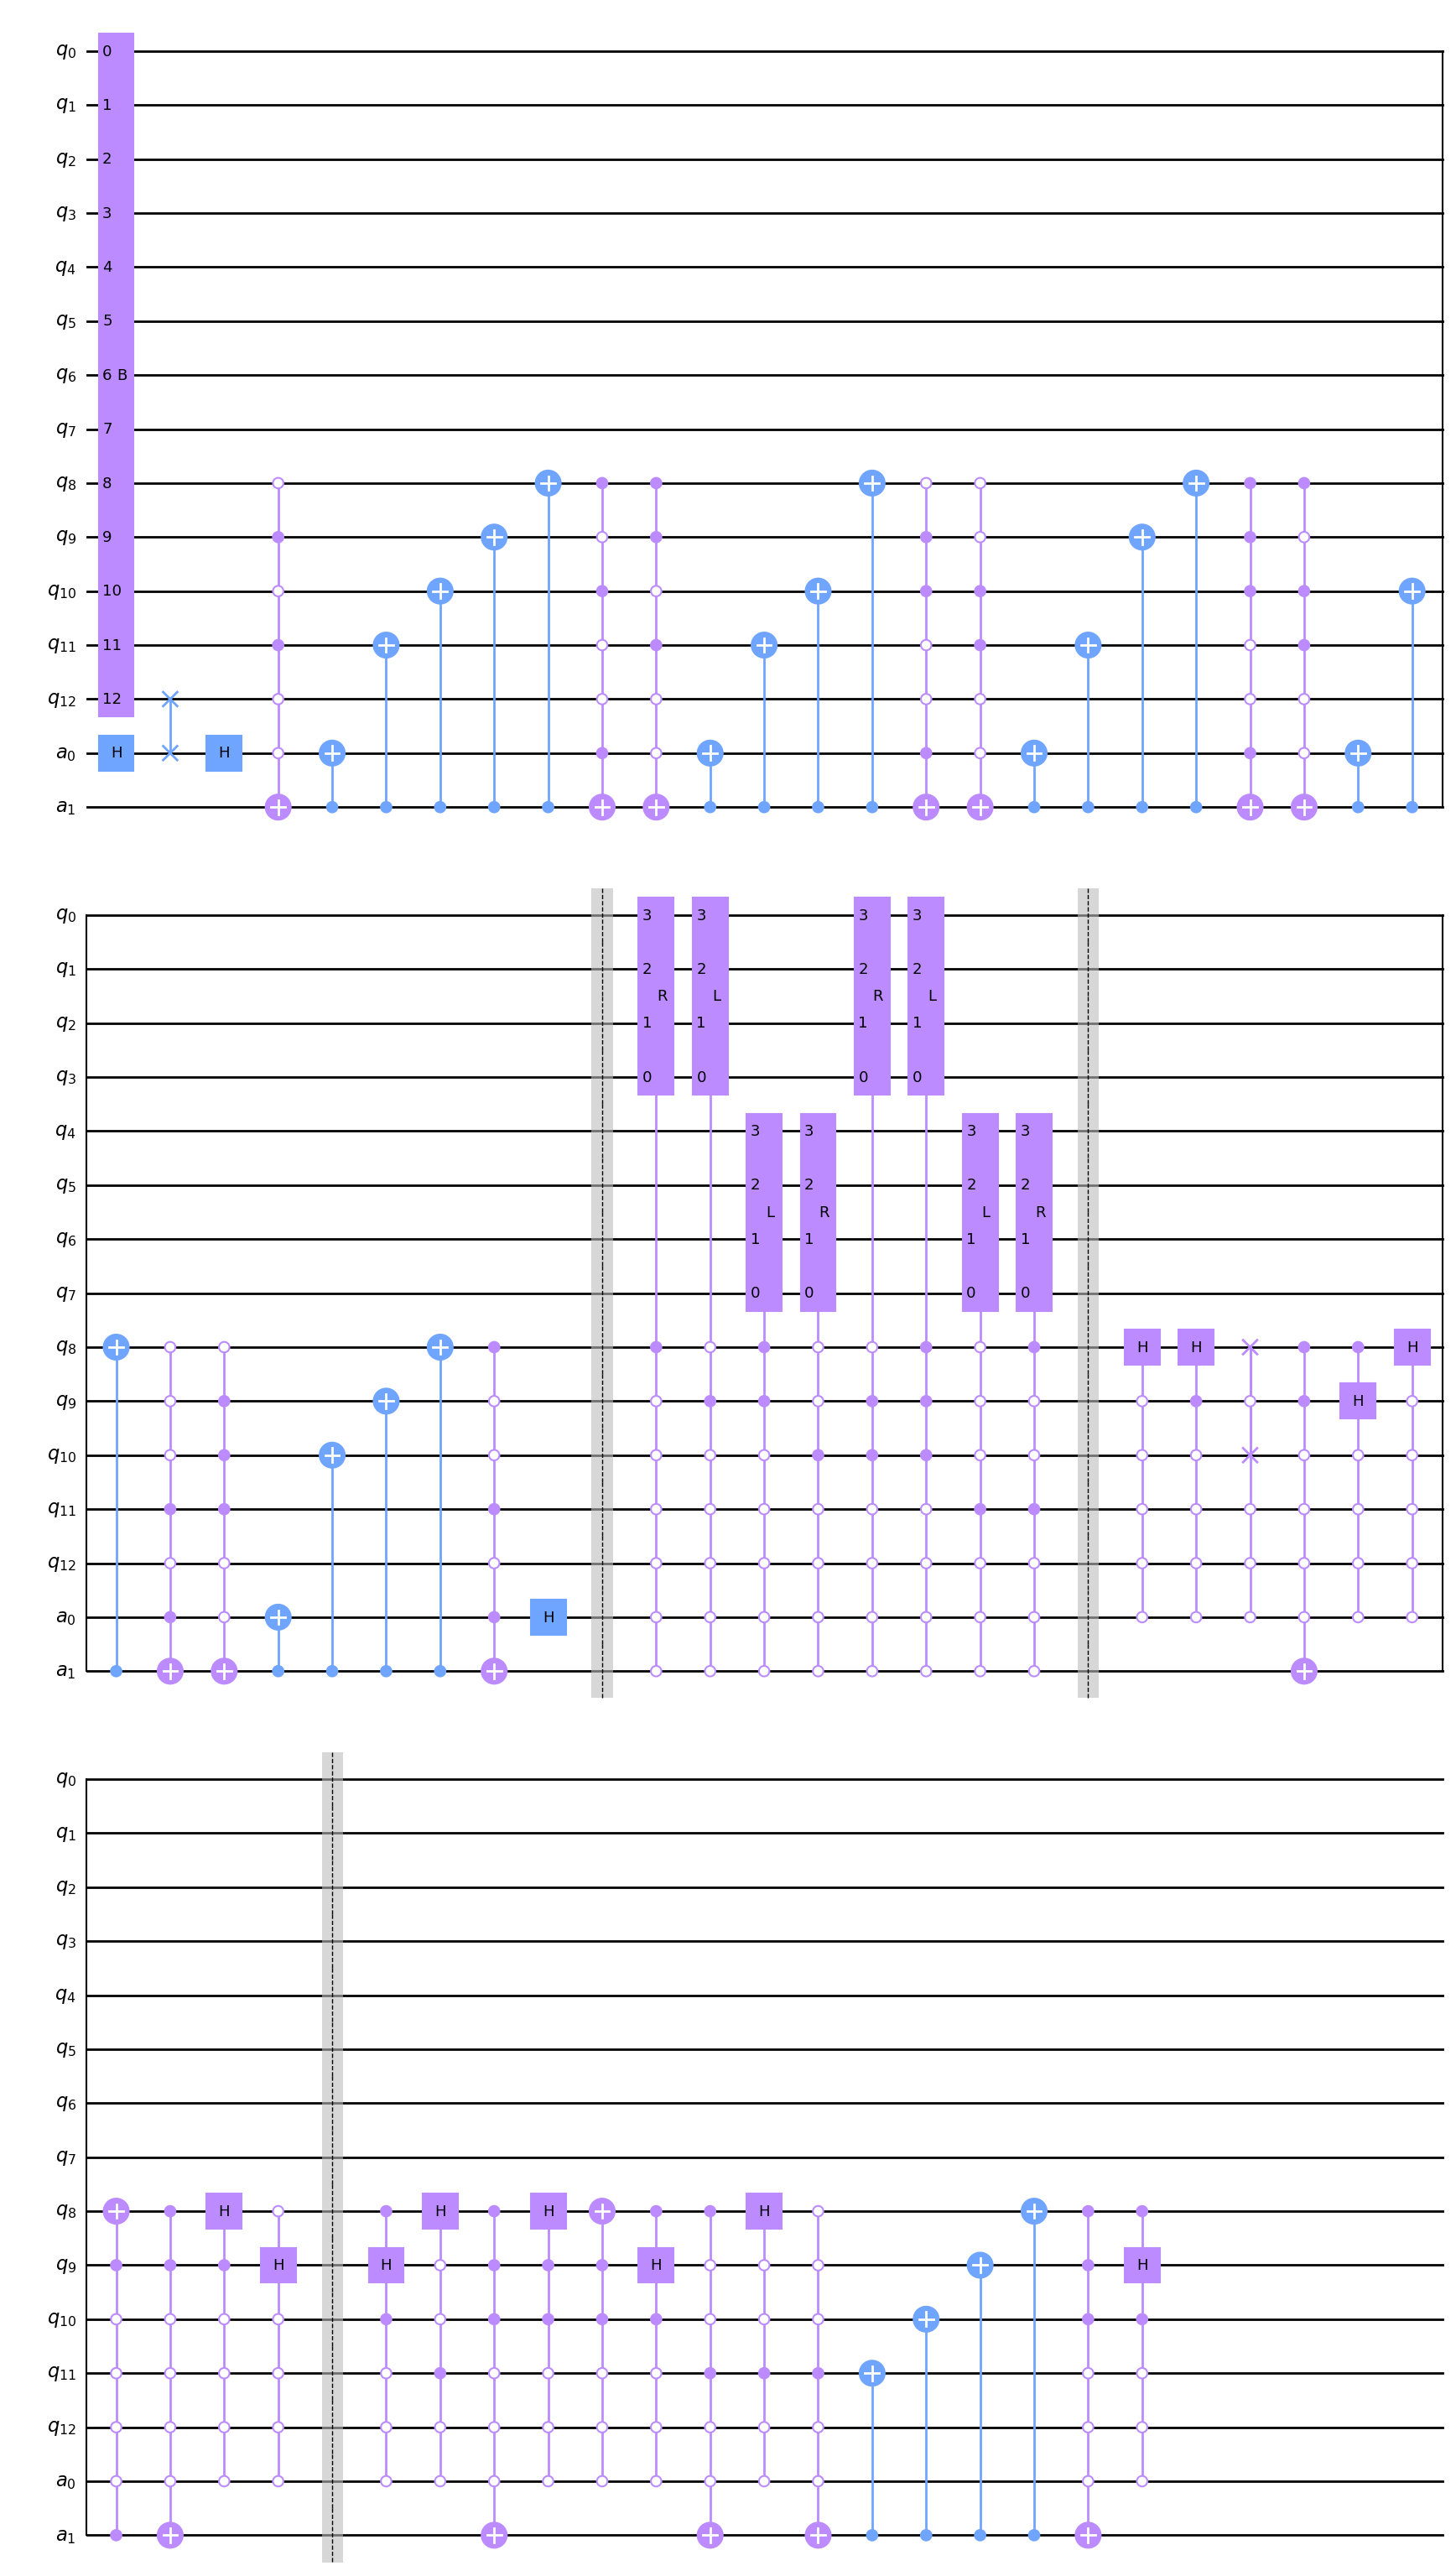

In [36]:
p1, p2 = createCirc(np.zeros((M,M)))
p1.draw()

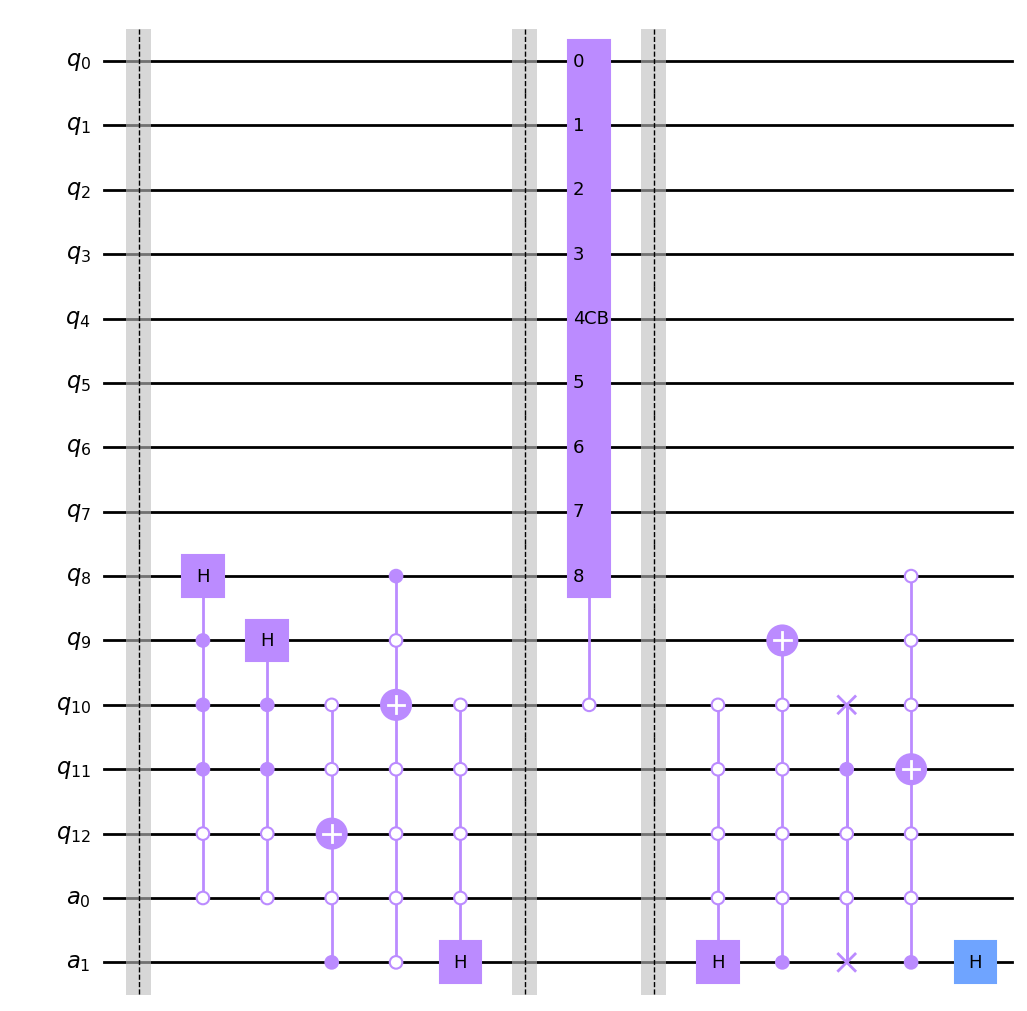

In [37]:
p2.draw()

In [10]:
def reinit(v,s):
    v = v.flatten()
    s = s.flatten()
    vorticity = np.concatenate((v.copy(),v.copy(),v.copy(),v.copy(),v.copy()))
    streamfunction = np.concatenate((s.copy(),s.copy(),s.copy(),s.copy(),s.copy()))

    source_term = vorticity.copy()

    vect = np.append(vorticity, np.append(streamfunction, np.append(source_term, calcBounds(s))))
    vect = np.append(vect, vect)
    SV = Statevector(vect).expand([1,0]).expand([1,0])
    return SV

In [11]:
allvorts = [np.zeros((M,M))]
allstreams = [np.zeros((M,M))]
timesteps = 80

In [12]:
for i in range(timesteps):
    print(i)
    v, s = allvorts[-1].flatten(), allstreams[-1].flatten()
    SV = reinit(v,s)
    part1, part2 = createCirc(s)
    
    SV = SV.evolve(part1)
    SVarr = np.array(SV)
    SVarr = np.real(SVarr)
    SV = Statevector(SVarr)
    SV = SV.evolve(part2)
    SVarr = np.array(SV)
    
    v, s = np.reshape(np.real(2**2.5*SVarr[:M**2]),(M,M)), np.reshape(np.real(2**2.5*SVarr[M**2:2*M**2]),(M,M))
    
    allvorts.append(v.copy())
    allstreams.append(s.copy())
    np.savetxt('oneCirc/stream'+str(i+1)+'.csv', allstreams[-1], delimiter=',')
    np.savetxt('oneCirc/vort'+str(i+1)+'.csv', allvorts[-1], delimiter=',')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [13]:
def graphC(st,it,levels):
    fig, ax = plt.subplots()
    CS = ax.contour(np.arange(16), np.arange(16), st, levels = levels)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('t='+str(it))
    ax.set_aspect('equal', adjustable='box')

/var/folders/jp/s01ry41n1ksb327qbnx4y_bh0000gn/T/ipykernel_65753/1556795467.py:3: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(np.arange(16), np.arange(16), st, levels = levels)


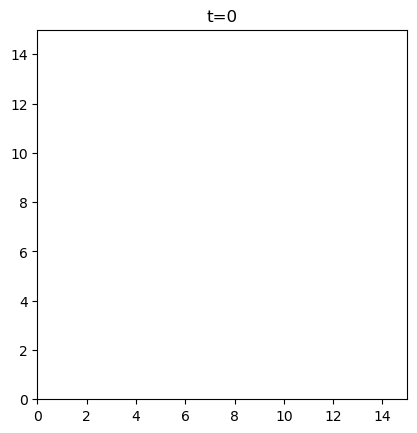

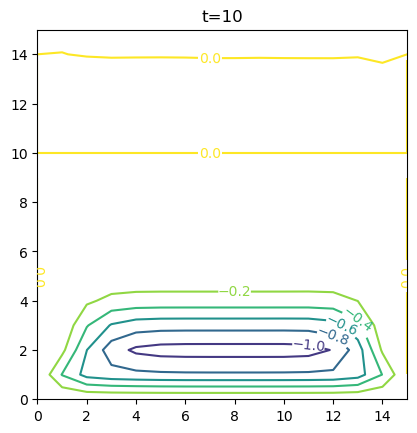

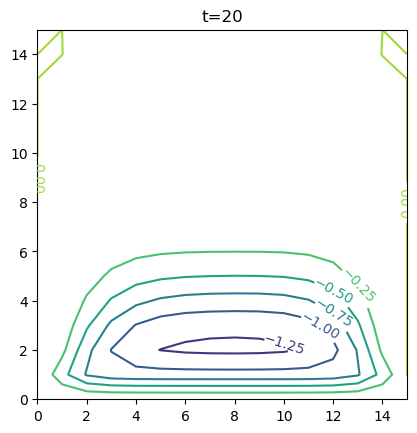

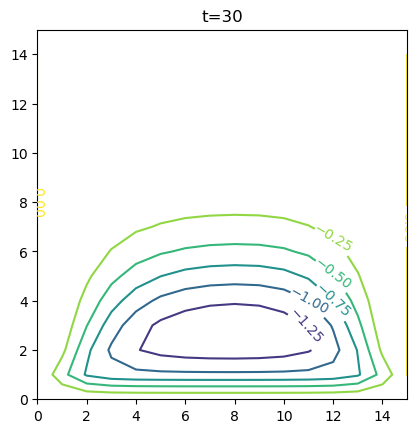

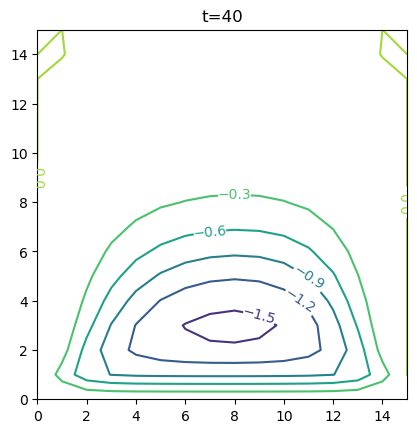

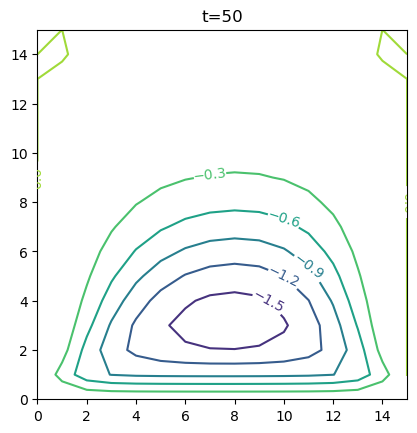

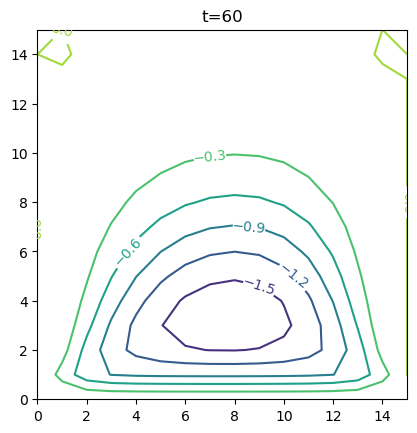

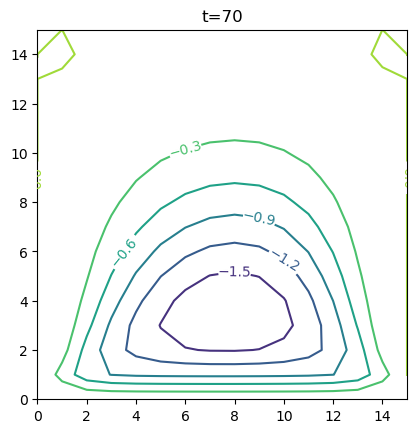

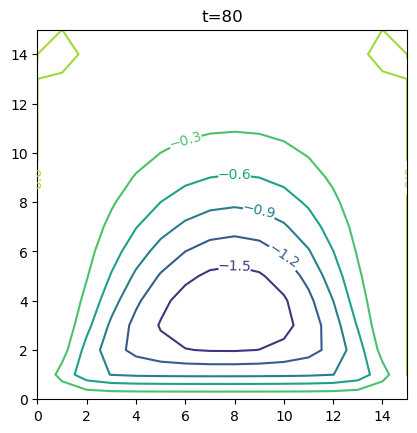

In [14]:
for i in range(9):
    graphC(allstreams[10*i],10*i,5)